# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [33]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

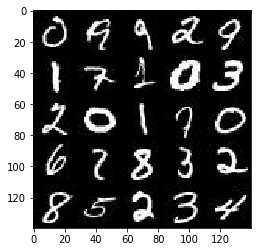

In [34]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

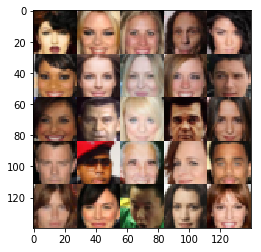

In [35]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [36]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [37]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    in_learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    return input_real, input_z, in_learning_rate
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [38]:
def discriminator(images, reuse=False, alpha=0.1, std=0.02):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # hidden layer 1
        h1 = tf.layers.conv2d(images, 32, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=std))
        h1 = tf.maximum(alpha * h1, h1)
        
        # hidden layer 2
        h2 = tf.layers.conv2d(h1, 64, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=std))
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        # hidden layer 3
        h3 = tf.layers.conv2d(h2, 128, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=std))
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        
        # hidden layer 4
        h4 = tf.layers.conv2d(h2, 256, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=std))
        h4 = tf.layers.batch_normalization(h4, training=True)
        h4 = tf.maximum(alpha * h4, h4)
        
        flat = tf.reshape(h2, (-1, 2*2*256))
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.random_normal_initializer(stddev=std))
        output = tf.sigmoid(logits)
        
        return output, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [40]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01, std=0.02):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # hidden layer 1
        h1 = tf.layers.dense(z, 4 * 4 * 512)
        h1 = tf.reshape(h1, (-1, 4, 4, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        
        # hidden layer 2
        h2 = tf.layers.conv2d_transpose(h1, 128, 4, 1, padding='valid', kernel_initializer=tf.random_normal_initializer(stddev=std))
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        
        # hidden layer 3
        h3 = tf.layers.conv2d_transpose(h2, 64, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=std))
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
        
        # hidden layer 4
        h4 = tf.layers.conv2d_transpose(h3, 32, 5, 2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=std))
        h4 = tf.layers.batch_normalization(h4, training=is_train)
        h4 = tf.maximum(alpha * h4, h4)
        
        logits = tf.layers.conv2d_transpose(h4, out_channel_dim, 3, 1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=std))
        output = tf.tanh(logits)
        
        return output
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [41]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    generator = generator(input_z, out_channel_dim)
    
    # get discriminator output and logits with real data
    discriminator_real, discriminator_logits_real = discriminator(input_real)
    
    # get discriminator output and logits with generated data
    discriminator_gen, discriminator_logits_gen = discriminator(gen_model, reuse=True)
    
    # calculate discriminator loss for real and generated data
    discriminator_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real, labels=tf.ones_like(discriminator_logits_real) * 0.9))
    discriminator_loss_gen = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_gen, labels=tf.zeros_like(discriminator_logits_gen)))
    
    # calculate total discriminator loss
    discriminator_loss = discriminator_loss_real + discriminator_loss_gen

    # calcualte generator loss
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_gen, labels=tf.ones_like(discriminator_logits_gen)))
    
    return dis_loss, gen_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [42]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # add discriminator and generator training variables to the graph
    train_vars = tf.trainable_variables()
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [op for op in update_ops if op.name.startswith('generator')]

    with tf.control_dependencies(gen_updates):
        d_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        return d_train_ops, g_train_ops
      
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [43]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [44]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # define image dimensions
    _, image_width, image_height, image_channels = data_shape
    
    # define model inputs
    input_real, input_z, in_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # calculate model loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # define model optimization
    d_ops, g_ops = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # define counter variables for printing status
    batch_counter = 0
    print_loss = 10
    print_gen_output = 100

    # train model
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_counter += 1
                # rescale images between -1 and 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # evaluate optimization of discriminator and generator
                _ = sess.run(d_ops, feed_dict={ input_real: batch_images, input_z: batch_z, in_learning_rate: learning_rate })
                _ = sess.run(g_ops, feed_dict={ input_z: batch_z, in_learning_rate: learning_rate })
                
                # print loss every X batches as defined by print_loss variable
                if batch_counter % print_loss == 0:
                    d_loss_train = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    g_loss_train = g_loss.eval({input_z: batch_z})
                    print("Epoch {epoch}...".format(epoch=i+1),
                         "D Loss: {:.4f}...".format(d_loss_train),
                         "G Loss: {:.4f}".format(g_loss_train))
                # show generator output every X batches as defined by print_gen_output variable
                if batch_counter % print_gen_output == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2895... Generator Loss: 0.6613
Epoch 1/2... Discriminator Loss: 1.2074... Generator Loss: 0.7439
Epoch 1/2... Discriminator Loss: 1.3156... Generator Loss: 0.7840
Epoch 1/2... Discriminator Loss: 1.3352... Generator Loss: 0.8247
Epoch 1/2... Discriminator Loss: 1.3378... Generator Loss: 0.8294
Epoch 1/2... Discriminator Loss: 1.3303... Generator Loss: 0.8000
Epoch 1/2... Discriminator Loss: 1.3314... Generator Loss: 0.8837
Epoch 1/2... Discriminator Loss: 1.3057... Generator Loss: 0.8327
Epoch 1/2... Discriminator Loss: 1.2993... Generator Loss: 0.8364
Epoch 1/2... Discriminator Loss: 1.2942... Generator Loss: 0.8679


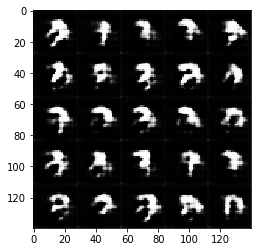

Epoch 1/2... Discriminator Loss: 1.2910... Generator Loss: 0.9293
Epoch 1/2... Discriminator Loss: 1.2985... Generator Loss: 0.8666
Epoch 1/2... Discriminator Loss: 1.2649... Generator Loss: 0.8757
Epoch 1/2... Discriminator Loss: 1.2838... Generator Loss: 0.9285
Epoch 1/2... Discriminator Loss: 1.3293... Generator Loss: 1.0038
Epoch 1/2... Discriminator Loss: 1.3616... Generator Loss: 0.7325
Epoch 1/2... Discriminator Loss: 1.2635... Generator Loss: 1.0207
Epoch 1/2... Discriminator Loss: 1.3600... Generator Loss: 0.7731
Epoch 1/2... Discriminator Loss: 1.3772... Generator Loss: 0.7002
Epoch 1/2... Discriminator Loss: 1.3155... Generator Loss: 0.9678


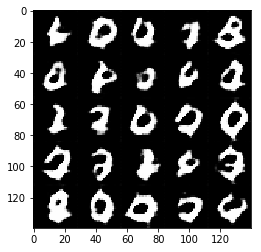

Epoch 1/2... Discriminator Loss: 1.3410... Generator Loss: 0.7446
Epoch 1/2... Discriminator Loss: 1.3026... Generator Loss: 0.7389
Epoch 1/2... Discriminator Loss: 1.3126... Generator Loss: 0.8597
Epoch 1/2... Discriminator Loss: 1.3453... Generator Loss: 0.8004
Epoch 1/2... Discriminator Loss: 1.2628... Generator Loss: 0.8618
Epoch 1/2... Discriminator Loss: 1.3648... Generator Loss: 0.8447
Epoch 1/2... Discriminator Loss: 1.3728... Generator Loss: 0.7882
Epoch 1/2... Discriminator Loss: 1.3288... Generator Loss: 0.8805
Epoch 1/2... Discriminator Loss: 1.3376... Generator Loss: 0.8062
Epoch 1/2... Discriminator Loss: 1.3281... Generator Loss: 0.8858


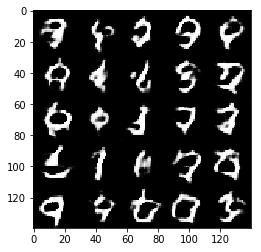

Epoch 1/2... Discriminator Loss: 1.3579... Generator Loss: 0.8823
Epoch 1/2... Discriminator Loss: 1.3313... Generator Loss: 0.8388
Epoch 1/2... Discriminator Loss: 1.3637... Generator Loss: 0.7982
Epoch 1/2... Discriminator Loss: 1.3589... Generator Loss: 0.9958
Epoch 1/2... Discriminator Loss: 1.3151... Generator Loss: 0.7895
Epoch 1/2... Discriminator Loss: 1.3799... Generator Loss: 0.7797
Epoch 1/2... Discriminator Loss: 1.3594... Generator Loss: 0.8220
Epoch 1/2... Discriminator Loss: 1.3597... Generator Loss: 0.8976
Epoch 1/2... Discriminator Loss: 1.3561... Generator Loss: 0.8401
Epoch 1/2... Discriminator Loss: 1.3622... Generator Loss: 0.8007


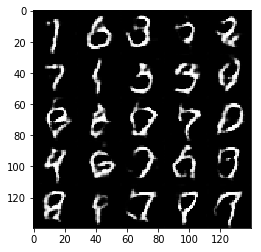

Epoch 1/2... Discriminator Loss: 1.3634... Generator Loss: 0.7830
Epoch 1/2... Discriminator Loss: 1.3547... Generator Loss: 0.8064
Epoch 1/2... Discriminator Loss: 1.3504... Generator Loss: 0.8914
Epoch 1/2... Discriminator Loss: 1.3671... Generator Loss: 0.7945
Epoch 1/2... Discriminator Loss: 1.3295... Generator Loss: 0.8433
Epoch 1/2... Discriminator Loss: 1.3709... Generator Loss: 0.7845
Epoch 1/2... Discriminator Loss: 1.3793... Generator Loss: 0.6672
Epoch 1/2... Discriminator Loss: 1.3852... Generator Loss: 0.8260
Epoch 1/2... Discriminator Loss: 1.3565... Generator Loss: 0.7952
Epoch 1/2... Discriminator Loss: 1.3426... Generator Loss: 0.8396


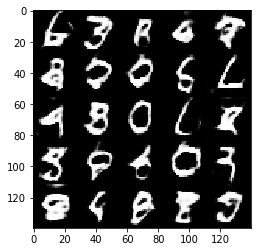

Epoch 1/2... Discriminator Loss: 1.3705... Generator Loss: 0.8337
Epoch 1/2... Discriminator Loss: 1.3682... Generator Loss: 0.8602
Epoch 1/2... Discriminator Loss: 1.3509... Generator Loss: 0.8553
Epoch 1/2... Discriminator Loss: 1.3577... Generator Loss: 0.7281
Epoch 1/2... Discriminator Loss: 1.3737... Generator Loss: 0.8741
Epoch 1/2... Discriminator Loss: 1.3367... Generator Loss: 0.8170
Epoch 1/2... Discriminator Loss: 1.3628... Generator Loss: 0.8336
Epoch 1/2... Discriminator Loss: 1.3716... Generator Loss: 0.6893
Epoch 1/2... Discriminator Loss: 1.3425... Generator Loss: 0.8327
Epoch 1/2... Discriminator Loss: 1.3502... Generator Loss: 0.8953


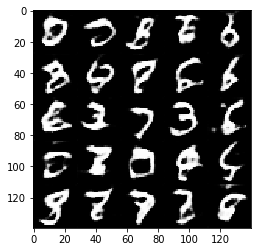

Epoch 1/2... Discriminator Loss: 1.3749... Generator Loss: 0.9929
Epoch 1/2... Discriminator Loss: 1.3658... Generator Loss: 0.7962
Epoch 1/2... Discriminator Loss: 1.3400... Generator Loss: 0.8791
Epoch 1/2... Discriminator Loss: 1.3618... Generator Loss: 0.8955
Epoch 1/2... Discriminator Loss: 1.3592... Generator Loss: 0.7402
Epoch 1/2... Discriminator Loss: 1.3490... Generator Loss: 0.7797
Epoch 1/2... Discriminator Loss: 1.3782... Generator Loss: 0.6828
Epoch 1/2... Discriminator Loss: 1.3542... Generator Loss: 0.7603
Epoch 1/2... Discriminator Loss: 1.3364... Generator Loss: 0.8344
Epoch 1/2... Discriminator Loss: 1.3604... Generator Loss: 0.7931


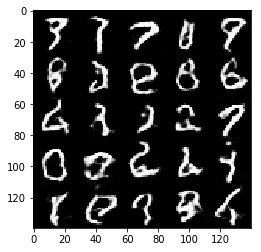

Epoch 1/2... Discriminator Loss: 1.3309... Generator Loss: 0.8825
Epoch 1/2... Discriminator Loss: 1.3572... Generator Loss: 0.7742
Epoch 1/2... Discriminator Loss: 1.3633... Generator Loss: 0.7951
Epoch 1/2... Discriminator Loss: 1.3495... Generator Loss: 0.8711
Epoch 1/2... Discriminator Loss: 1.3585... Generator Loss: 0.9467
Epoch 1/2... Discriminator Loss: 1.3533... Generator Loss: 0.7979
Epoch 1/2... Discriminator Loss: 1.3321... Generator Loss: 0.9111
Epoch 1/2... Discriminator Loss: 1.3897... Generator Loss: 0.7825
Epoch 1/2... Discriminator Loss: 1.3428... Generator Loss: 0.8341
Epoch 1/2... Discriminator Loss: 1.3363... Generator Loss: 0.8110


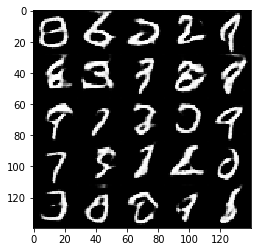

Epoch 1/2... Discriminator Loss: 1.3530... Generator Loss: 0.7286
Epoch 1/2... Discriminator Loss: 1.4668... Generator Loss: 0.5619
Epoch 1/2... Discriminator Loss: 1.3273... Generator Loss: 0.8769
Epoch 1/2... Discriminator Loss: 1.3146... Generator Loss: 0.8933
Epoch 1/2... Discriminator Loss: 1.4243... Generator Loss: 0.8610
Epoch 1/2... Discriminator Loss: 1.3858... Generator Loss: 0.7912
Epoch 1/2... Discriminator Loss: 1.4111... Generator Loss: 0.8254
Epoch 1/2... Discriminator Loss: 1.3413... Generator Loss: 0.8329
Epoch 1/2... Discriminator Loss: 1.3849... Generator Loss: 1.0216
Epoch 1/2... Discriminator Loss: 1.3169... Generator Loss: 0.8424


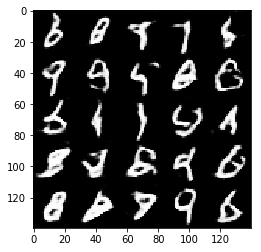

Epoch 1/2... Discriminator Loss: 1.3288... Generator Loss: 0.8395
Epoch 1/2... Discriminator Loss: 1.3984... Generator Loss: 0.9140
Epoch 1/2... Discriminator Loss: 1.3247... Generator Loss: 0.7948
Epoch 2/2... Discriminator Loss: 1.3720... Generator Loss: 0.8876
Epoch 2/2... Discriminator Loss: 1.3500... Generator Loss: 0.9660
Epoch 2/2... Discriminator Loss: 1.2938... Generator Loss: 0.9424
Epoch 2/2... Discriminator Loss: 1.3690... Generator Loss: 0.8792
Epoch 2/2... Discriminator Loss: 1.3475... Generator Loss: 0.8453
Epoch 2/2... Discriminator Loss: 1.3551... Generator Loss: 0.8194
Epoch 2/2... Discriminator Loss: 1.3370... Generator Loss: 0.8033


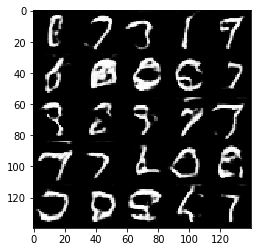

Epoch 2/2... Discriminator Loss: 1.3295... Generator Loss: 0.8687
Epoch 2/2... Discriminator Loss: 1.3719... Generator Loss: 0.8026
Epoch 2/2... Discriminator Loss: 1.3184... Generator Loss: 0.9511
Epoch 2/2... Discriminator Loss: 1.3692... Generator Loss: 0.7930
Epoch 2/2... Discriminator Loss: 1.3350... Generator Loss: 0.8323
Epoch 2/2... Discriminator Loss: 1.3604... Generator Loss: 0.8220
Epoch 2/2... Discriminator Loss: 1.3492... Generator Loss: 0.8105
Epoch 2/2... Discriminator Loss: 1.3243... Generator Loss: 0.8225
Epoch 2/2... Discriminator Loss: 1.3528... Generator Loss: 0.8270
Epoch 2/2... Discriminator Loss: 1.3740... Generator Loss: 0.9472


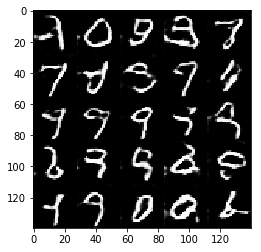

Epoch 2/2... Discriminator Loss: 1.3210... Generator Loss: 0.9171
Epoch 2/2... Discriminator Loss: 1.3680... Generator Loss: 0.8178
Epoch 2/2... Discriminator Loss: 1.3249... Generator Loss: 0.8248
Epoch 2/2... Discriminator Loss: 1.3159... Generator Loss: 0.8386
Epoch 2/2... Discriminator Loss: 1.3241... Generator Loss: 0.8915
Epoch 2/2... Discriminator Loss: 1.3416... Generator Loss: 0.8668
Epoch 2/2... Discriminator Loss: 1.3166... Generator Loss: 0.8305
Epoch 2/2... Discriminator Loss: 1.3476... Generator Loss: 0.8277
Epoch 2/2... Discriminator Loss: 1.3394... Generator Loss: 0.7790
Epoch 2/2... Discriminator Loss: 1.3770... Generator Loss: 0.6682


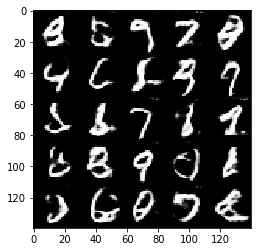

Epoch 2/2... Discriminator Loss: 1.3605... Generator Loss: 0.8950
Epoch 2/2... Discriminator Loss: 1.3786... Generator Loss: 0.6663
Epoch 2/2... Discriminator Loss: 1.3353... Generator Loss: 0.8326
Epoch 2/2... Discriminator Loss: 1.3484... Generator Loss: 0.8420
Epoch 2/2... Discriminator Loss: 1.3455... Generator Loss: 0.8305
Epoch 2/2... Discriminator Loss: 1.3151... Generator Loss: 0.8018
Epoch 2/2... Discriminator Loss: 1.3222... Generator Loss: 0.8188
Epoch 2/2... Discriminator Loss: 1.3210... Generator Loss: 0.8688
Epoch 2/2... Discriminator Loss: 1.2894... Generator Loss: 0.9159
Epoch 2/2... Discriminator Loss: 1.3223... Generator Loss: 0.8507


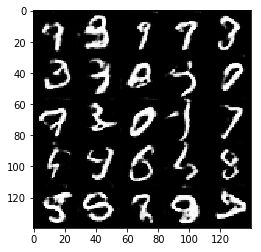

Epoch 2/2... Discriminator Loss: 1.4167... Generator Loss: 1.1815
Epoch 2/2... Discriminator Loss: 1.3602... Generator Loss: 0.8321
Epoch 2/2... Discriminator Loss: 1.3581... Generator Loss: 0.8099
Epoch 2/2... Discriminator Loss: 1.3478... Generator Loss: 0.8524
Epoch 2/2... Discriminator Loss: 1.3203... Generator Loss: 0.7892
Epoch 2/2... Discriminator Loss: 1.3358... Generator Loss: 0.8815
Epoch 2/2... Discriminator Loss: 1.3664... Generator Loss: 0.7717
Epoch 2/2... Discriminator Loss: 1.3256... Generator Loss: 0.8368
Epoch 2/2... Discriminator Loss: 1.3333... Generator Loss: 0.8056
Epoch 2/2... Discriminator Loss: 1.3347... Generator Loss: 0.8816


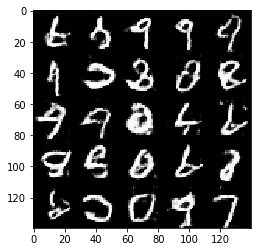

Epoch 2/2... Discriminator Loss: 1.4315... Generator Loss: 1.0072
Epoch 2/2... Discriminator Loss: 1.3880... Generator Loss: 0.8110
Epoch 2/2... Discriminator Loss: 1.3826... Generator Loss: 0.7760
Epoch 2/2... Discriminator Loss: 1.3542... Generator Loss: 0.9135
Epoch 2/2... Discriminator Loss: 1.3417... Generator Loss: 0.8161
Epoch 2/2... Discriminator Loss: 1.3268... Generator Loss: 0.8458
Epoch 2/2... Discriminator Loss: 1.3203... Generator Loss: 0.8033
Epoch 2/2... Discriminator Loss: 1.3586... Generator Loss: 0.7700
Epoch 2/2... Discriminator Loss: 1.4415... Generator Loss: 0.5834
Epoch 2/2... Discriminator Loss: 1.3517... Generator Loss: 0.7522


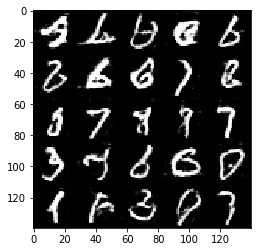

Epoch 2/2... Discriminator Loss: 1.3411... Generator Loss: 0.7806
Epoch 2/2... Discriminator Loss: 1.3816... Generator Loss: 0.8354
Epoch 2/2... Discriminator Loss: 1.3590... Generator Loss: 0.8205
Epoch 2/2... Discriminator Loss: 1.3431... Generator Loss: 0.9131
Epoch 2/2... Discriminator Loss: 1.3743... Generator Loss: 0.7592
Epoch 2/2... Discriminator Loss: 1.3346... Generator Loss: 0.8376
Epoch 2/2... Discriminator Loss: 1.3835... Generator Loss: 0.8546
Epoch 2/2... Discriminator Loss: 1.3654... Generator Loss: 0.7888
Epoch 2/2... Discriminator Loss: 1.3620... Generator Loss: 0.7691
Epoch 2/2... Discriminator Loss: 1.3045... Generator Loss: 0.8686


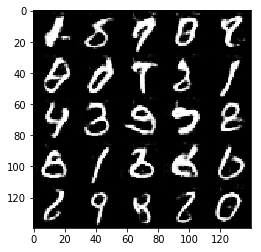

Epoch 2/2... Discriminator Loss: 1.3446... Generator Loss: 0.7489
Epoch 2/2... Discriminator Loss: 1.3485... Generator Loss: 0.7935
Epoch 2/2... Discriminator Loss: 1.3350... Generator Loss: 0.8062
Epoch 2/2... Discriminator Loss: 1.3457... Generator Loss: 0.8185
Epoch 2/2... Discriminator Loss: 1.3405... Generator Loss: 0.8480
Epoch 2/2... Discriminator Loss: 1.3535... Generator Loss: 0.7730
Epoch 2/2... Discriminator Loss: 1.3418... Generator Loss: 0.8196
Epoch 2/2... Discriminator Loss: 1.3624... Generator Loss: 0.8492
Epoch 2/2... Discriminator Loss: 1.3495... Generator Loss: 0.7495
Epoch 2/2... Discriminator Loss: 1.3152... Generator Loss: 0.8728


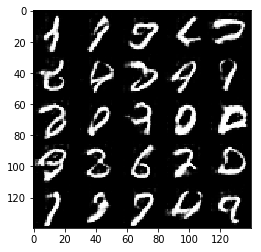

Epoch 2/2... Discriminator Loss: 1.3741... Generator Loss: 0.6628
Epoch 2/2... Discriminator Loss: 1.3348... Generator Loss: 0.8578
Epoch 2/2... Discriminator Loss: 1.3782... Generator Loss: 0.6478
Epoch 2/2... Discriminator Loss: 1.3334... Generator Loss: 0.8379
Epoch 2/2... Discriminator Loss: 1.3324... Generator Loss: 0.8628
Epoch 2/2... Discriminator Loss: 1.3710... Generator Loss: 0.7831
Epoch 2/2... Discriminator Loss: 1.3651... Generator Loss: 0.8000
Epoch 2/2... Discriminator Loss: 1.3378... Generator Loss: 0.7553
Epoch 2/2... Discriminator Loss: 1.3416... Generator Loss: 0.8119
Epoch 2/2... Discriminator Loss: 1.4109... Generator Loss: 0.7219


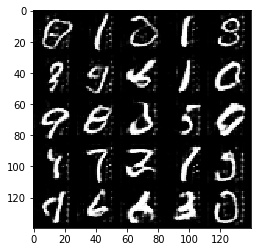

Epoch 2/2... Discriminator Loss: 1.3401... Generator Loss: 0.8408
Epoch 2/2... Discriminator Loss: 1.3503... Generator Loss: 0.8105
Epoch 2/2... Discriminator Loss: 1.3507... Generator Loss: 0.8002
Epoch 2/2... Discriminator Loss: 1.3408... Generator Loss: 0.8421
Epoch 2/2... Discriminator Loss: 1.3300... Generator Loss: 0.8460
Epoch 2/2... Discriminator Loss: 1.3343... Generator Loss: 0.7959
Epoch 2/2... Discriminator Loss: 1.3554... Generator Loss: 0.8333


In [45]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 1.0163
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 1.1349
Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 0.9515
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 1.1711
Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 0.9309
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 1.2351
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.8089


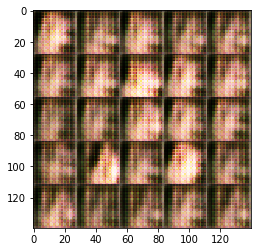

Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 1.0426
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 1.1079
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 1.1066
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 1.1655
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 1.0085
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.9784
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 1.3805
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 1.3835


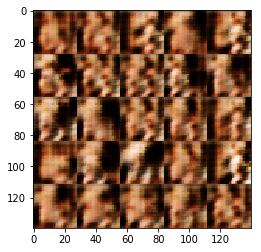

Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 1.1776
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 1.0449
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 1.1442
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 1.0189
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 1.0693
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 1.1353
Epoch 1/1... Discriminator Loss: 1.0420... Generator Loss: 1.1132
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 1.1124


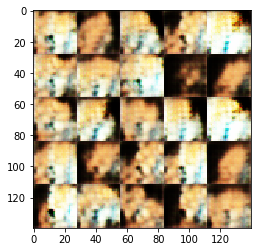

Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 1.1341
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 1.0210
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.9418
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.8379
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.8526


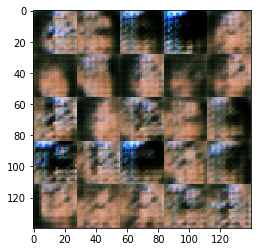

Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 1.0100
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.9276
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.8956
Epoch 1/1... Discriminator Loss: 1.5943... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 0.9933
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.9144
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.9002


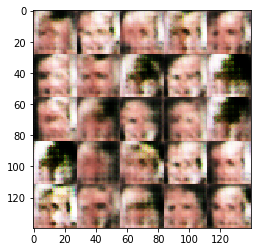

Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.9308
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.9955
Epoch 1/1... Discriminator Loss: 1.2291... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.8894
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.8897
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.9087
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.9391


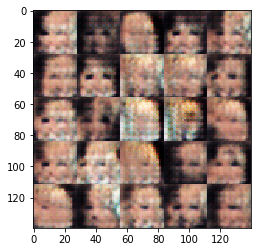

Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.9057
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 2.7571... Generator Loss: 1.1078
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.9722
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.8887
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.9781


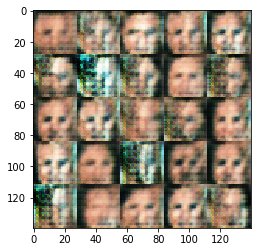

Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.9332
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.8989
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 1.1241
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.8987
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.9836
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.8411


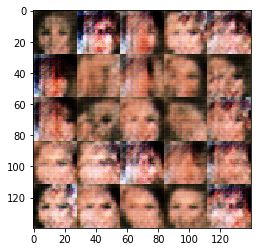

Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.8762
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.8898
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.8511
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.8603


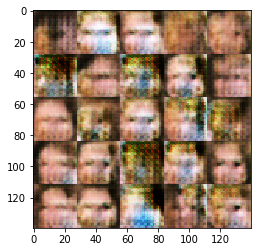

Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.9943
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.8735
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 1.0409


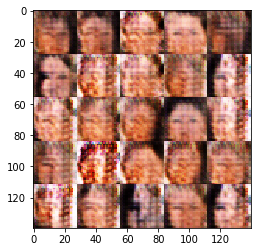

Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.8444
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.8765
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.8996


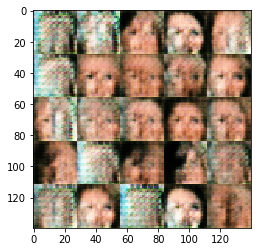

Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.9546
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.9149
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.8880


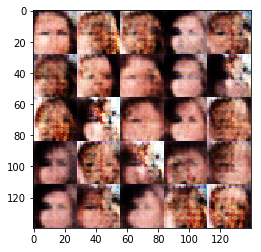

Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.8817
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.8617
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.8444
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.8494


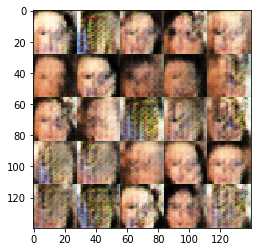

Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 1.7787... Generator Loss: 0.9041
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.9122
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.8412
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.8559


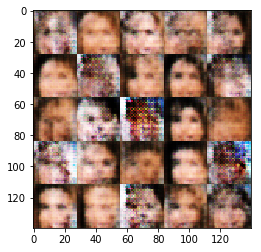

Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.8631
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.8148


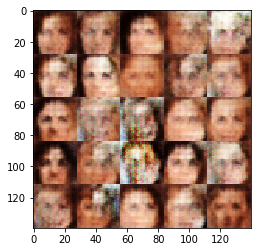

Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.9010
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.8877


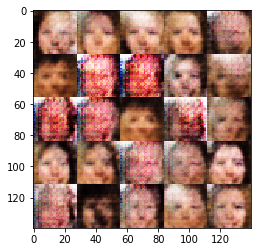

Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.5150... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.8682
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.8127


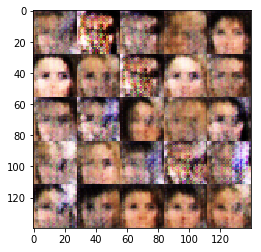

Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.8637


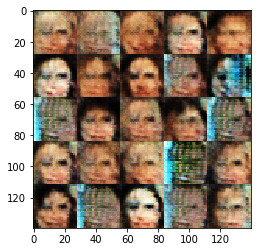

Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.8262


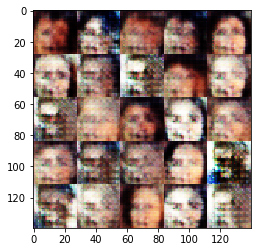

Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.8769
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.8286


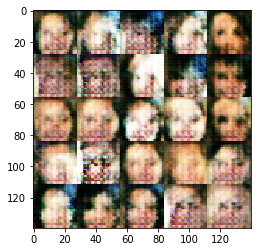

Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.8189


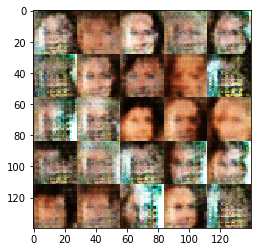

Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.8625
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.5803... Generator Loss: 0.9075
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7975


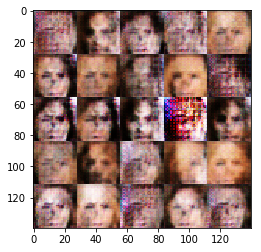

Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.7940


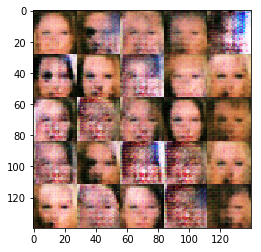

Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.8327


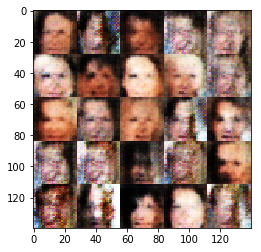

Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.8942
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.8453


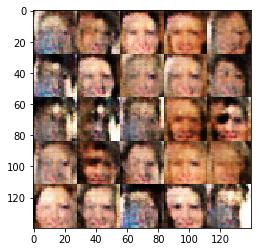

Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.8727
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.8222


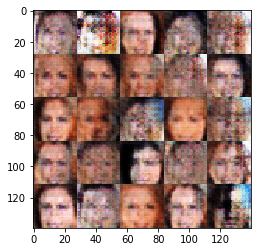

In [54]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.